# Reflection in Hot Jupiters 

This notebook will look at how albedo and reflection is computed in POSEIDON and assumes familiarity with emission.ipynb, cloud_tutorial_transmission.ipynb, and scattering.ipynb. (And to some degree, the PT_profiles.ipynb)

In emission geometries (secondary eclipse, direct emission), directional scattering becomes important. 

In particular, reflection requires scattering (whether it be Rayeligh scattering, which is symmetric, or aerosol scattering, which can have strong back-scattering cross sections).

Hot Jupiters are expected to be either dark due to alkali absorption, or bright due to silicate cloud reflection (with alkali absorption imprinted on the reflection).

To learn more about albedo spectra in exoplanets, we refer readers to Sudarsky 2000 (https://arxiv.org/pdf/astro-ph/9910504)

For this notebook, we will take a look at how reflection affects the emission spectra of a hot jupiter. 

We have implemented the Toon reflection from PICASO (https://arxiv.org/pdf/1904.09355), see (https://natashabatalha.github.io/picaso_dev), into POSEIDON. 

If reflection is used, please cite both Batalha 2019 and Mullens 2024. 

In order to utilize this feature, set reflection=True into forward model. 

For more details of the actual code, see reflection_Toon() in emission.py in POSEIDON, and get_reflected_1d() in fluxes.py in PICASO.

## Example: HD 189733b Secondary Eclipse

Here we use HD 189733b as a test case. We define a clear model with no reflection, a clear model with reflection, and a model with MgSiO3 (enstatite) aerosols (slab model, patchy)

For reflection, there are a few things to be noted. 

1. The user must include the planet's distance from it's host star into the create_planet() function via a_p = 'distance from host star'
2. Below, we define the wavelength grid to be linear from 0.2 to 1 um. This is because reflection utlized a tridiagonal matrix solver that can be slow, and wavenumber resolution can crowd the UVIS wavelengths with points. 
3. When we define our model, we introduce three new options 
- reflection = True (turns on reflection)
- Na_K_fixed_ratio = True (this just makes it to where log_K = 0.1 log_Na)
- reflection_up_to_5um = True (computed albedo only up to 5 um, to speed up calculations)

In [1]:
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.core import create_star, create_planet, load_data, define_model, \
                          wl_grid_constant_R, set_priors, read_opacities
from POSEIDON.visuals import plot_data, plot_spectra_retrieved, plot_PT_retrieved
from POSEIDON.retrieval import run_retrieval
from POSEIDON.utility import read_retrieved_spectrum, read_retrieved_PT, \
                             read_retrieved_log_X, plot_collection
from POSEIDON.corner import generate_cornerplot

import numpy as np
from scipy.constants import au
from scipy.constants import parsec as pc

#***** Model wavelength grid *****#

wl_min = 0.2     # Minimum wavelength (um)
wl_max = 5     # Maximum wavelength (um)
R = 5000         # Spectral resolution of grid

# We need to provide a model wavelength grid to initialise instrument properties
wl_1 = np.linspace(wl_min, 1.0, 1000)[:-1]
wl_2 = wl_grid_constant_R(1.0, wl_max, R)
wl_2 = wl_2[1:]    # Indexing to avoid 1.0 um being repeated twice
wl = np.concatenate((wl_1, wl_2))

#***** Define planet properties *****#

planet_name = 'HD 189733b'  # Planet name used for plots, output files etc.

R_p = 1.13*R_J    # Planetary radius (m)
M_p = 1.129*M_J
d = 19.7638*pc
#d_err = 0.005*pc # Error in a priori system distance
a_p = 0.03142*au

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, a_p = a_p)


#***** Define stellar properties *****#

R_s = 0.78*R_Sun      # Stellar radius (m)
T_s = 5014         # Stellar effective temperature (K)
Met_s = 0.13          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.58       # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

#***** Define model *****#

model_name_shiny_deck = 'HD189-ER-Patchy-Shiny-Deck'

#***** Define model *****#

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2', 'H2O', 'K','Na',]

# Create the model object
model_shiny_deck = define_model(model_name_shiny_deck, bulk_species, param_species, 
                     PT_profile = 'Guillot_dayside',
                     cloud_model = 'MacMad17',cloud_type = 'shiny_deck',
                     scattering = True, reflection = True, 
                     Na_K_fixed_ratio = True,
                     reflection_up_to_5um = True,
                     cloud_dim = 2)

model_name = 'Fuzzy_Deck_SiO2'

# Set aerosol species
aerosol_species = ['SiO2']  # <---- Put aerosol species here

# Define model
model_shiny_fuzzy_deck = define_model(model_name, bulk_species, param_species,
                                PT_profile = 'Guillot_dayside', X_profile = 'isochem',
                                cloud_model = 'Mie',                 # <---- Put cloud model here (Mie)
                                cloud_type = 'shiny_fuzzy_deck',           # <---- Put cloud type here 
                                aerosol_species = aerosol_species,   # <---- Put aerosol species list here 
                                scattering = True, reflection = True, 
                                Na_K_fixed_ratio = True,
                                reflection_up_to_5um = True,
                                )   

model_name = 'Opaque_deck_plus_uniform_X'

aerosol_species = ['SiO2'] # <---- Put aerosol species here

model_shiny_deck_UX = define_model(model_name, bulk_species, param_species,
                                        PT_profile = 'Guillot_dayside', X_profile = 'isochem',
                                        cloud_model = 'Mie',cloud_type = 'shiny_opaque_deck_plus_uniform_X', # <---- Put cloud type here 
                                        aerosol_species = aerosol_species,
                                        scattering = True, reflection = True, 
                                        Na_K_fixed_ratio = True,
                                        reflection_up_to_5um = True,) # <---- Put aerosol species list here 

model_name = 'Opaque_deck_plus_slab'

aerosol_species = ['SiO2'] # <---- Put aerosol species here

model_shiny_deck_slab = define_model(model_name, bulk_species, param_species,
                                        PT_profile = 'Guillot_dayside', X_profile = 'isochem',
                                        cloud_model = 'Mie',cloud_type = 'shiny_opaque_deck_plus_slab', # <---- Put cloud type here 
                                        aerosol_species = aerosol_species,
                                        scattering = True, reflection = True, 
                                        Na_K_fixed_ratio = True,
                                        reflection_up_to_5um = True,) # <---- Put aerosol species list here 


print(model_shiny_deck['param_names'])
print(model_shiny_fuzzy_deck['param_names'])
print(model_shiny_deck_UX['param_names'])
print(model_shiny_deck_slab['param_names'])


Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...
['R_p_ref' 'log_kappa_IR' 'log_gamma' 'T_int' 'T_equ' 'log_CO' 'log_CO2'
 'log_H2O' 'log_Na' 'log_P_cloud' 'albedo_deck' 'phi_cloud']
['R_p_ref' 'log_kappa_IR' 'log_gamma' 'T_int' 'T_equ' 'log_CO' 'log_CO2'
 'log_H2O' 'log_Na' 'albedo_deck' 'log_P_top_deck_SiO2' 'log_r_m_SiO2'
 'log_n_max_SiO2' 'f_SiO2']
['R_p_ref' 'log_kappa_IR' 'log_gamma' 'T_int' 'T_equ' 'log_CO' 'log_CO2'
 'log_H2O' 'log_Na' 'albedo_deck' 'log_P_top_deck' 'log_r_m_SiO2'
 'log_X_SiO2']
['R_p_ref' 'log_kappa_IR' 'log_gamma' 'T_int' 'T_equ' 'log_CO' 'log_CO2'
 'log_H2O' 'log_Na' 'albedo_deck' 'log_P_top_deck' 'log_P_top_slab_SiO2'
 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2']


Now we load in the cross sections.

In [2]:
#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100    # Same as prior range for T
T_fine_max = 3000    # Same as prior range for T
T_fine_step = 20     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-6   # 10 nbar
P_max = 100       # 10 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # Retrieved R_p_ref parameter will be the radius at 10 bar

#***** Run atmospheric retrieval *****#
opac = read_opacities(model_shiny_deck, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
CO2-H2 done
CO2-CO2 done
CO done
CO2 done
H2O done
Na done
K done
Opacity pre-interpolation complete.


In [21]:
from POSEIDON.core import make_atmosphere

R_p_ref               =   1.12 * R_J

log_kappa_IR          =   -4.82 
log_gamma             =   -0.42 
T_int                 =   255.7 
T_equ                 =   1159.5

log_CO                =   -5.30 
log_CO2               =   -3.07 
log_H2O               =   -5.33  
log_Na                =   -6.59 

log_P_cloud = -1
albedo_deck = 0.5
phi_cloud = 1

log_P_top_deck_SiO2 = 0     # <---- Top of the opaque deck is at 1 bar (extends from 100 to 1 bar)
log_r_m_SiO2        = -2    # <---- Mean particle size of the SiO2 aerosols is 1e-2 microns
log_n_max_SiO2      = 10    # <---- The number density of SiO2 at the top of the opaque deck (at 1 bar)
f_SiO2              = 0.3   # <---- The fuzziness of aerosols (how number density evolves above the cloud deck)

log_P_top_slab_SiO2 = -5  # <---- The top of the slab in pressure space (at 1e-5 bars)
Delta_log_P_SiO2    = 2   # <---- Extend of the slab in pressure space (extends down to 1e-3 bars)
log_r_m_SiO2        = -2  # <---- Mean particle size of the SiO2 aerosols is 1e-2 microns
log_X_SiO2          = -12 # <---- Volume mixing ratio of aerosol in the slab (1e-5 to 1e-3 bars)


PT_params = np.array([log_kappa_IR, log_gamma, T_int, T_equ])

log_X_params = np.array([log_CO, log_CO2, log_H2O, log_Na,])

cloud_params = np.array([log_P_cloud, albedo_deck, phi_cloud])

atmosphere_shiny_deck = make_atmosphere(planet, model_shiny_deck, P, P_ref, R_p_ref, 
                                              PT_params, log_X_params, cloud_params)

cloud_params = np.array([albedo_deck, log_P_top_deck_SiO2, log_r_m_SiO2, log_n_max_SiO2, f_SiO2])

atmosphere_shiny_fuzzy_deck = make_atmosphere(planet, model_shiny_fuzzy_deck, P, P_ref, R_p_ref, 
                                              PT_params, log_X_params, cloud_params)

cloud_params = np.array([albedo_deck, log_P_cloud, log_r_m_SiO2 ,log_X_SiO2])

atmosphere_shiny_deck_ux = make_atmosphere(planet, model_shiny_deck_UX, P, P_ref, R_p_ref, 
                                              PT_params, log_X_params, cloud_params)

cloud_params = np.array([albedo_deck,log_P_cloud, log_P_top_slab_SiO2, Delta_log_P_SiO2, log_r_m_SiO2 ,log_X_SiO2])

atmosphere_shiny_deck_slab = make_atmosphere(planet, model_shiny_deck_slab, P, P_ref, R_p_ref, 
                                              PT_params, log_X_params, cloud_params)

Now lets compute some spectra! 

When computing spectra with reflection turned on, theres also an option to turn on 'return_albedo', which will return the geometric albedo computed by the reflection function. 

In [22]:
from POSEIDON.core import compute_spectrum

Fp_Fs_shiny_deck = compute_spectrum(planet, star, model_shiny_deck, atmosphere_shiny_deck, opac, wl, 
                                          spectrum_type = 'emission') 

Fp_Fs_shiny_fuzzy_deck = compute_spectrum(planet, star, model_shiny_fuzzy_deck, atmosphere_shiny_fuzzy_deck, opac, wl, 
                                          spectrum_type = 'emission') 

Fp_Fs_shiny_deck_ux = compute_spectrum(planet, star, model_shiny_deck_UX, atmosphere_shiny_deck_ux, opac, wl, 
                                          spectrum_type = 'emission') 

Fp_Fs_shiny_deck_slab = compute_spectrum(planet, star, model_shiny_deck_slab, atmosphere_shiny_deck_slab, opac, wl, 
                                          spectrum_type = 'emission') 

Generate the plots

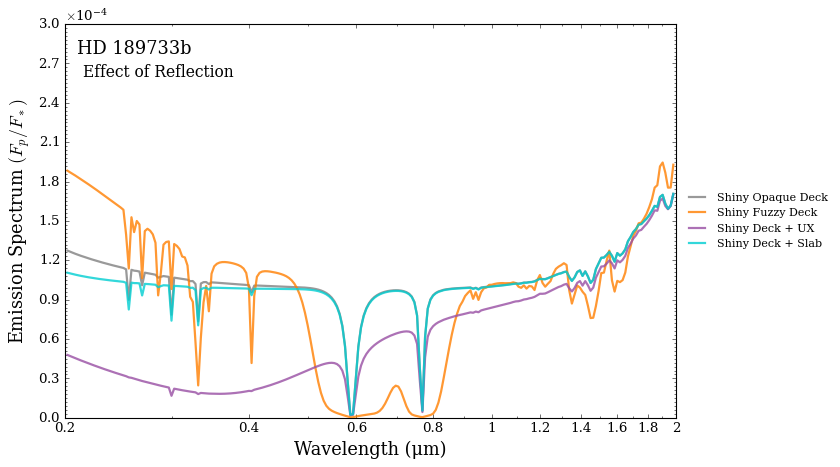

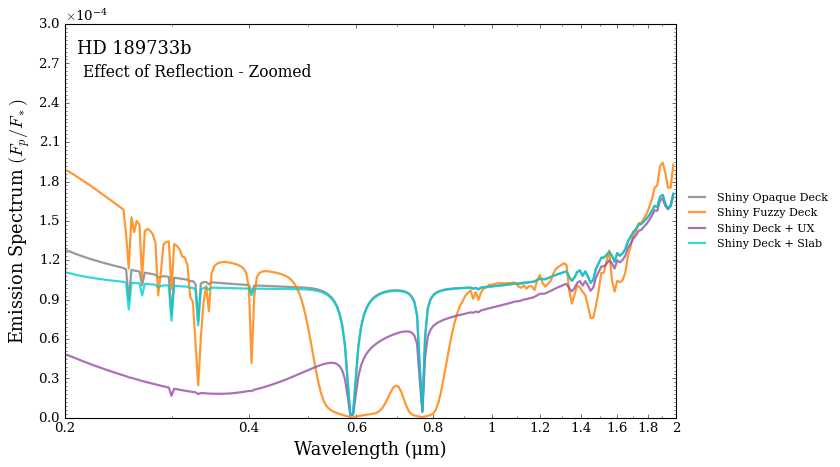

In [23]:
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

spectra = []

# Add the three model spectra to the plot collection object
spectra = plot_collection(Fp_Fs_shiny_deck, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_shiny_fuzzy_deck, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_shiny_deck_ux, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_shiny_deck_slab, wl, collection = spectra)

# Plot spectra
title = 'Effect of Reflection'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', spectra_labels = ['Shiny Opaque Deck','Shiny Fuzzy Deck','Shiny Deck + UX', 'Shiny Deck + Slab'],
                        legend_location = 'outside right', wl_axis = 'log', colour_list = ['gray', '#ff7f00', '#984ea3', 'darkturquoise'],
                        plt_label = title,
                        figure_shape = 'wide')

# Produce figure and save to file
title = 'Effect of Reflection - Zoomed'

fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', spectra_labels = ['Shiny Opaque Deck','Shiny Fuzzy Deck','Shiny Deck + UX', 'Shiny Deck + Slab'],
                        legend_location = 'outside right', wl_axis = 'log', colour_list = ['gray', '#ff7f00', '#984ea3', 'darkturquoise'],
                        plt_label = title,
                        figure_shape = 'wide',
                        wl_max = 2, y_max = 0.3e-3)

## Reflection Parameter Exploration

Lets shorten the wavelength array to just focus on the 0.2 to 2 um region

To do this, we make a new opac, recreate the star object. 

We also recreate the parameter lists.

In [9]:
wl_min = 0.2     # Minimum wavelength (um)
wl_max = 2     # Maximum wavelength (um)
R = 5000         # Spectral resolution of grid

# We need to provide a model wavelength grid to initialise instrument properties
wl_1 = np.linspace(wl_min, 1.0, 1000)[:-1]
wl_2 = wl_grid_constant_R(1.0, wl_max, R)
wl_2 = wl_2[1:]    # Indexing to avoid 1.0 um being repeated twice
wl = np.concatenate((wl_1, wl_2))

opac = read_opacities(model_shiny_deck, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
CO2-H2 done
CO2-CO2 done
CO done
CO2 done
H2O done
Na done
K done
Opacity pre-interpolation complete.


In [10]:
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

In [11]:
R_p_ref               =   1.12 * R_J

log_kappa_IR          =   -4.82 
log_gamma             =   -0.42 
T_int                 =   255.7 
T_equ                 =   1159.5

log_CO                =   -5.30 
log_CO2               =   -3.07 
log_H2O               =   -5.33  
log_Na                =   -6.59 

log_P_cloud = -1
albedo_deck = 0.5
phi_cloud = 1


PT_params = np.array([log_kappa_IR, log_gamma, T_int, T_equ])

log_X_params = np.array([log_CO, log_CO2, log_H2O, log_Na,])

cloud_params = np.array([log_P_cloud, albedo_deck, phi_cloud])


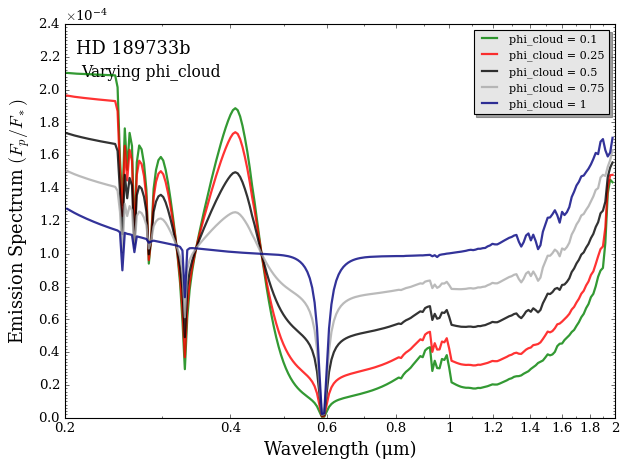

In [12]:
from POSEIDON.clouds import vary_one_parameter

param_name = 'phi_cloud'
vary_list = [0.1, 0.25, 0.5, 0.75, 1]


vary_one_parameter(model_shiny_deck, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                       spectrum_type = 'emission', y_unit = 'Fp/Fs')

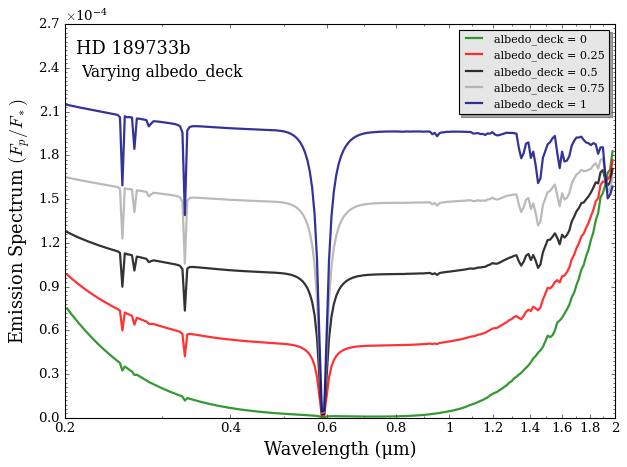

In [13]:
#from POSEIDON.clouds import vary_one_parameter

param_name = 'albedo_deck'
vary_list = [0,0.25, 0.5, 0.75, 1]

vary_one_parameter(model_shiny_deck, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                       spectrum_type = 'emission', y_unit = 'Fp/Fs')

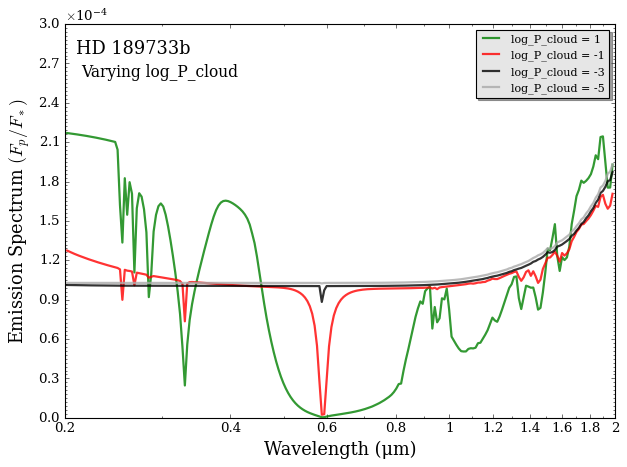

In [14]:
#from POSEIDON.clouds import vary_one_parameter

param_name = 'log_P_cloud'
vary_list = [1,-1,-3,-5]

vary_one_parameter(model_shiny_deck, planet, star, param_name, vary_list,
                       wl, opac, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                       spectrum_type = 'emission', y_unit = 'Fp/Fs')